In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
%matplotlib inline
from keras.utils import plot_model
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
# Image size
im_width = 400
im_height = 400
path_train_x = 'training/images/'
path_train_y = 'training/groundtruth/'

In [3]:
def load_images(path, x=True):
    ids = next(os.walk(path))[2]
    N = len(ids)
    images = np.empty((len(ids), im_height, im_width, 3 if x else 1))
    for i, id_ in enumerate(ids):
        if (x):
            img = load_img(path + id_, target_size=(400,400))
        else:
            img = load_img(path + id_, target_size=(400,400), color_mode="grayscale")
        images[i] = img_to_array(img)/255.
    return images

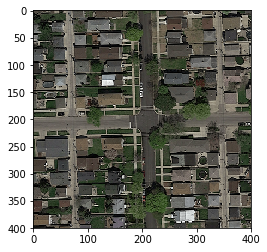

In [4]:
x = load_images(path_train_x)
y = load_images(path_train_y, x=False)
plt.imshow(x[0])

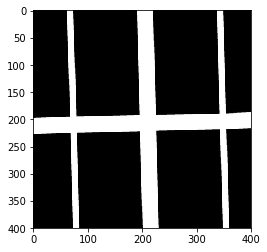

In [5]:
plt.imshow(y[0][:,:,0], cmap="gray")

In [6]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [11]:
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=2, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 400, 400, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 400, 400, 2)  56          img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 400, 400, 2)  8           conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 400, 400, 2)  0           batch_normalization_19[0][0]     
__________________________________________________________________________________________________
conv2d_21 

In [8]:
data = np.random.random((1000, 32))
val_data = np.random.random((1000, 32))
labels = np.random.random((1000, 10))
val_labels = np.random.random((1000, 10))

dataset = tf.data.Dataset.from_tensor_slices((data, labels))
dataset = dataset.batch(32).repeat()

val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
val_dataset = val_dataset.batch(32).repeat()

In [ ]:
plot_model(model, to_file='model.png')

In [12]:
# history = model.fit(dataset, epochs=50, steps_per_epoch=30, validation_data=val_dataset, validation_steps=3, verbose=1)
history = model.fit(x, y, validation_split=0.25, epochs=10, batch_size=16, verbose=1)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Train on 75 samples, validate on 25 samples
Epoch 1/10
75/75 [==============================] - 101s 1s/step - loss: 1.2140 - acc: 0.3699 - val_loss: 1.3857 - val_acc: 0.3193
Epoch 2/10
75/75 [==============================] - 87s 1s/step - loss: 1.1209 - acc: 0.3705 - val_loss: 1.5754 - val_acc: 0.3201
Epoch 3/10
48/75 [==================>...........] - ETA: 29s - loss: 1.0294 - acc: 0.3690

KeyboardInterrupt: 